In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from sklearn.metrics import adjusted_mutual_info_score
from diffusion_gibbs import DiffusionGibbs
from Dirichlet_sampling import DPSampler
import mpmath as mp

# Gibbs sampling

Let's import our dataset and the fiducial values that generated it.

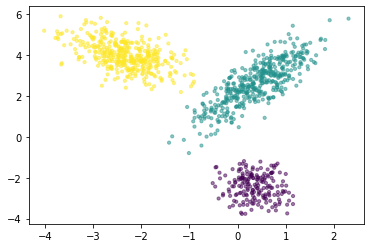

In [2]:
data_ = np.load('./data/data_new.npy')
data = data_[:,:-1]
plt.scatter(data[:,0], data[:,1], c=data_[:,2], s=10, alpha=0.5)
Pi = np.array([[0.19620123, 0.43338011, 0.37041866]])
mus = np.array([[0.34824985, -2.46339862], [0.31424805, 2.50411433], [-2.33069298, 3.99453242]])
Sigmas = np.array([[[0.12561104, -0.02830921], [-0.02830921, 0.39484784]],
                   [[0.35717756, 0.52362066], [0.52362066, 1.16519016]],
                   [[0.33196668, -0.21238558], [-0.21238558, 0.51249515]]])

We can now initialize an object from the class DiffusionGibbs and run the gibbs_sampler method.

In this case we put hot_start=0, which means that the clusters are built randomly. If hot_start=1, the clusters are initialized using k-means algorithm.

In [4]:
sampler=DiffusionGibbs(data, alpha=[1,2,1.5], hot_start=0, n_iter=4000)
gibbs=sampler.gibbs_sampler()

100%|██████████| 4000/4000 [00:12<00:00, 330.86it/s]


We can now plot the results for each cluster.

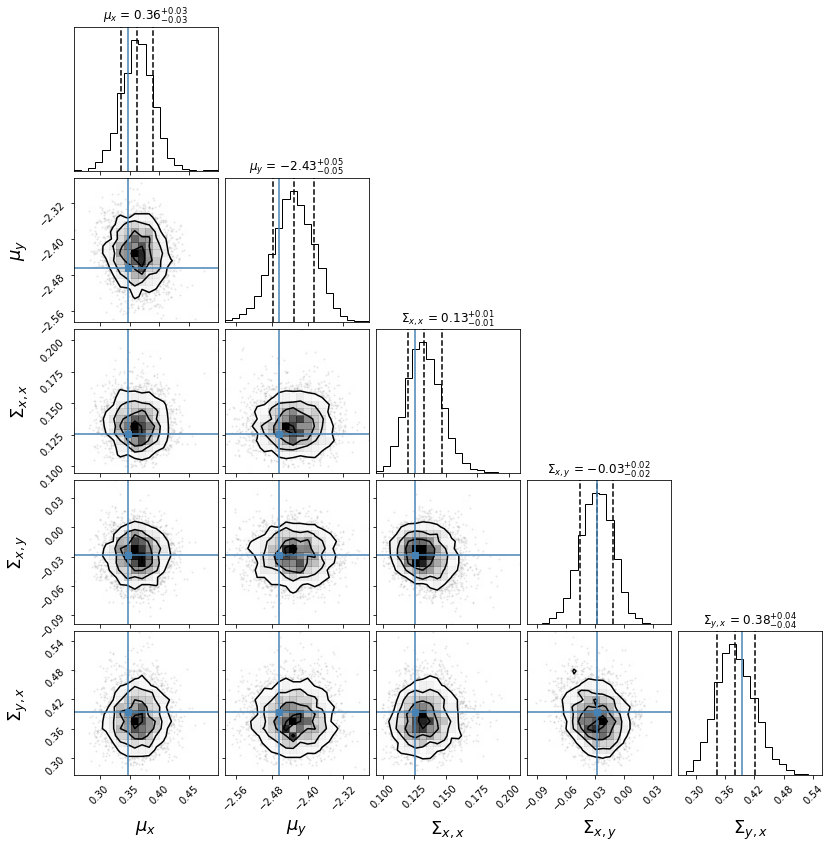

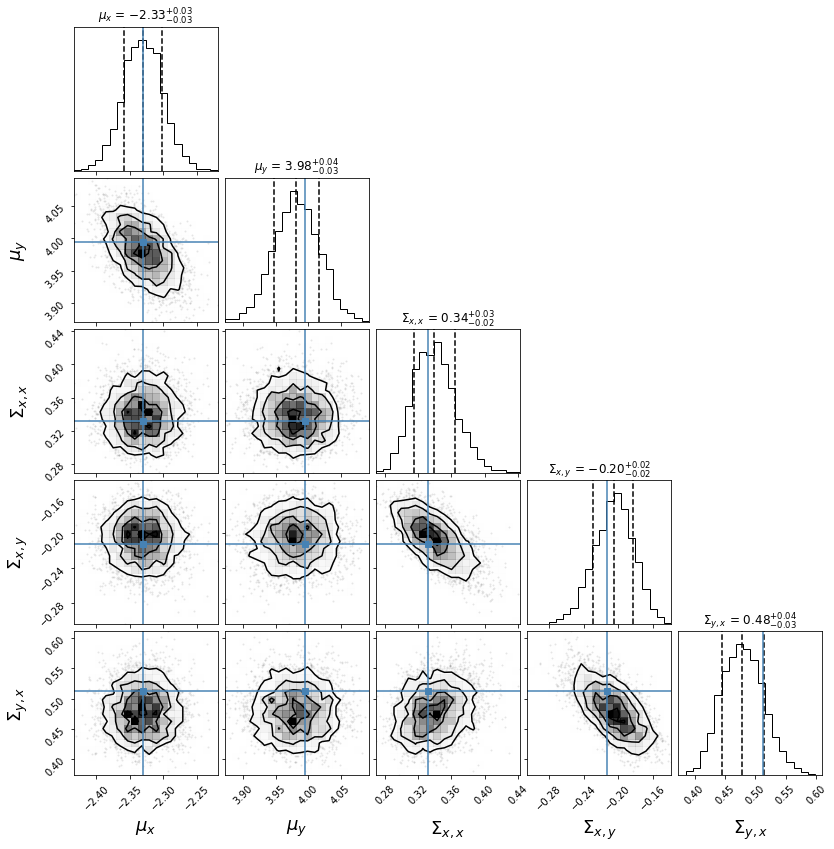

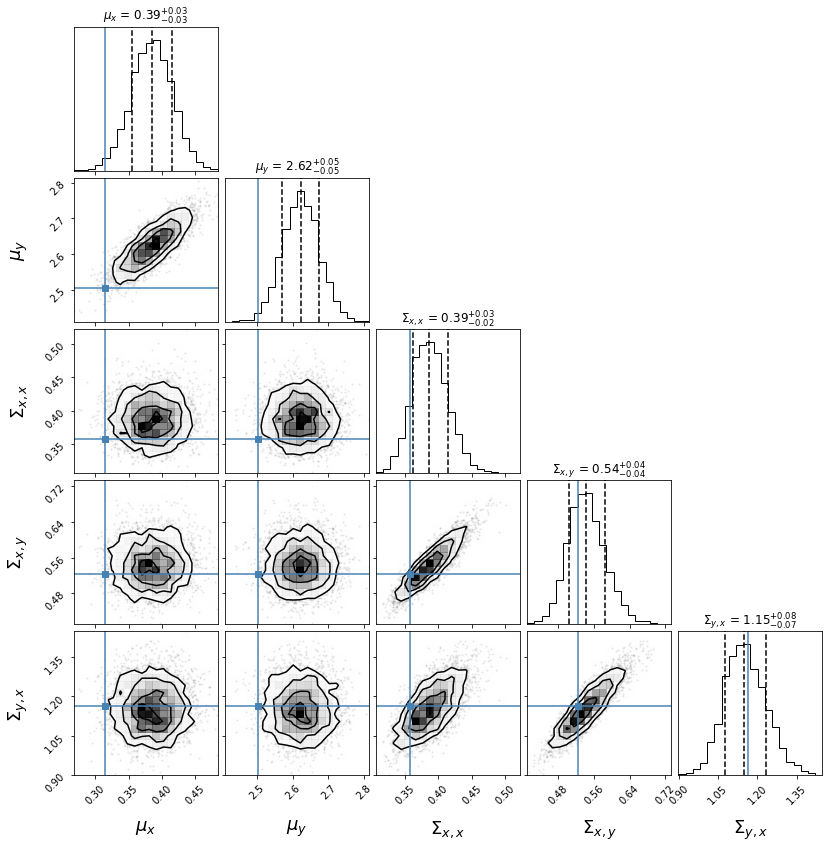

In [24]:
burnin=200
for i in range(3):
    # Let's put together the values of mu, and sigma
    cluster=np.hstack([np.array(gibbs['mus'])[burnin:,i,:], np.array(gibbs['Sigmas'])[burnin:,i,0,:].reshape(-1,2), np.array(gibbs['Sigmas'])[burnin:,i,1,1].reshape(-1,1)])
    # In order to solve the indecision on the cluster labels, we compare the probabilities with the fiducial ones
    j = np.argmin([abs(gibbs['pi'][-1][i]-Pi[0][0]),abs(gibbs['pi'][-1][i]-Pi[0][1]),abs(gibbs['pi'][-1][i]-Pi[0][2])]) 
    figure = corner(cluster[100:], 
                    labels=["$\mu_{x}$", "$\mu_{y}$", "$\Sigma_{x,x}$", "$\Sigma_{x,y}$", "$\Sigma_{y,x}$"], 
                    truths=[mus[j][0], mus[j][1], Sigmas[j][0, 0], Sigmas[j][0, 1], Sigmas[j][1, 1]],
                    show_titles=True, 
                    title_fmt=".2f", 
                    quantiles=[0.16, 0.5, 0.84], 
                    title_kwargs={"fontsize": 12},
                    label_kwargs={"fontsize":18})
    plt.show()

Let's now check how good the labelling is by comparing the assignements by the algorithm with the true assignements.

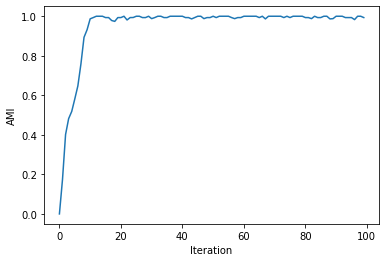

In [30]:
AMI=[]
for i in range(100):
    AMI.append(adjusted_mutual_info_score(gibbs['zi'][i], data_[:,2]))
plt.xlabel('Iteration')
plt.ylabel('AMI')
plt.plot(AMI)
plt.show()

# Dirichlet Process

Let's sample from a Dirichlet Process. 

We initialize the sampler with a number of cluster greater than the true one and with the assignments obtained from k-means.

This should prevent problems such as the 'freezing' of a number of labels smaller than the fiducial one.

In [4]:
Dir_sampler=DPSampler(data, hot_start=1, n_clusters_0=8, n_iter=100)
DP=Dir_sampler.run()

100%|██████████| 100/100 [01:28<00:00,  1.12it/s]


We can now see that (already with such a small number of iterations) we see that the number of clusters decreases and the labeling is more and more similar to the true one.

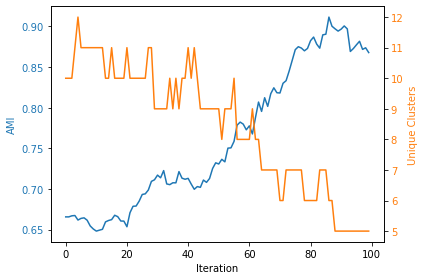

In [12]:
AMI=[]
for i in range(100):
    AMI.append(adjusted_mutual_info_score(DP['assignements'][i], data_[:,2]))
fig, ax1 = plt.subplots()
ax1.set_xlabel('Iteration')
ax1.set_ylabel('AMI', color='tab:blue')
ax1.plot(AMI, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
unique_clusters = [len(np.unique(DP['assignements'][i])) for i in range(100)]
ax2.set_ylabel('Unique Clusters', color='tab:orange')
ax2.plot(unique_clusters, color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
fig.tight_layout()
plt.show()

# Diffusive Gibbs Sampling for model selection

We show for a smaller dataset how to use Diffusive Gibbs Sampling for model selection.

Notice that Diffusive Gibbs Sampling can be used also for sampling purposes, in this case the method 'diffusion_gibbs' or 'parallel_diffusion_gibbs' (which parallelise the Gibbs steps at different temperatures) can be used. The amount of data generated increases with the number of iterations and temperatures considered.

In [3]:
alpha=[1,2,1.5]+[1]*10  

# for the arithmetic mean estimate
z_avgs=[]
var_z_avgs=[]
#for the harmonic mean estimate
rho=[]
var_rho=[]
#for the thermodynamic integration estimate
log_z_thints=[]
var_log_z_thints=[]
#for the stepping stone estimate
z_stepping_stones=[]
var_z_stepping_stones=[]


n_chains=25
n_gibbs_iter=20
burnin=200
n_iter=50

data_downsampled=data[::20]

In [4]:
for i in range(1,11):
    print('Computing evidence for {} clusters'.format(i))
    sampler=DiffusionGibbs(data_downsampled, alpha=alpha[:i], hot_start=1, n_iter=n_iter, n_clusters_0=i, allow_singular=True)
    
    sampler.init_params(0)

    _, (log_z_avg, log_z_avg_error), _, (log_rho, log_var_rho), th_int_res, log_stepping_stones = sampler.compute_evidence(n_chains=20, n_gibbs_iter=n_gibbs_iter)
    
    z_avgs.append(mp.exp(log_z_avg))
    var_z_avgs.append(mp.exp(log_z_avg_error))
    
    rho.append(mp.exp(log_rho))
    var_rho.append(mp.exp(log_var_rho))
    
    log_z_thints.append(th_int_res[0])
    var_log_z_thints.append(th_int_res[1])
    
    z_stepping_stones.append(mp.exp(log_stepping_stones[0]))
    var_z_stepping_stones.append(mp.exp(log_stepping_stones[1]))

Computing evidence for 1 clusters


100%|██████████| 50/50 [00:06<00:00,  7.37it/s]


Using the arithmetic mean method we get the following results: 3.30740014580256e-291 1.63398992098096e-307 -668.85609963495 -706.402598721064 2.66830345475354e-614 -1412.8058042381
Using the harmonic mean method we get the following results: 3.62563984667298e-92 4.77866966025316e-188 -210.549797773295 -431.321835288868 2.75823412616645e+91 2.76586844441432e+178 210.549834128062 410.877501223379
Using thermodynamic integration we get the following results: (mpf('-225.24181236582587'), mpf('0.014409126280957583'))
Using the stepping stone method we get the following results: (mpf('4.4245239138114111e-98'), mpf('6.9522365497441504e-198')) (mpf('-224.16617643084393'), mpf('-453.97278499929411'))
Computing evidence for 2 clusters


100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Using the arithmetic mean method we get the following results: 9.1319813049783e-387 1.2443613885226e-387 -888.888648307229 -890.881808531324 1.54749596598042e-774 -1781.76422385862
Using the harmonic mean method we get the following results: 1.07805145208214e-55 1.17585681023051e-113 -126.56702491412 -260.030118426272 9.2853991875258e+54 8.74091215276658e+106 126.568038208292 246.242034406896
Using thermodynamic integration we get the following results: (mpf('-191.69173829470913'), mpf('0.033514049792899799'))
Using the stepping stone method we get the following results: (mpf('3.7484546568607651e-83'), mpf('2.6858587063585851e-165')) (mpf('-189.7932190549603'), mpf('-378.93853985103857'))
Computing evidence for 3 clusters


100%|██████████| 50/50 [00:11<00:00,  4.39it/s]


Using the arithmetic mean method we get the following results: 3.07919359859938e-547 1.56408174862725e-547 -1258.38937812367 -1259.06674695804 2.44486773031476e-1094 -2518.13410071205
Using the harmonic mean method we get the following results: 5.13609943250273e-42 8.69431593441885e-86 -95.0722799796387 -195.859648526219 1.95346250172073e+41 1.26606421459185e+80 95.0755922526512 184.442720484386
Using thermodynamic integration we get the following results: (mpf('-186.00475225108892'), mpf('0.06547188166537099'))
Using the stepping stone method we get the following results: (mpf('1.88193266558817e-82'), mpf('1.2030876831534587e-165')) (mpf('-188.17967836310331'), mpf('-379.74164902260429'))
Computing evidence for 4 clusters


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


Using the arithmetic mean method we get the following results: 1.40671987145777e-340 1.41704012464233e-340 -782.537670956 -782.530361341054 2.00678463649497e-680 -1565.06132947808
Using the harmonic mean method we get the following results: 1.86764270017964e-41 3.16515543849926e-84 -93.7813117652382 -192.26494564542 5.40383177262582e+40 2.69899652067725e+79 93.7905120092172 182.897102391449
Using thermodynamic integration we get the following results: (mpf('-173.14659916561197'), mpf('0.041159993839673281'))
Using the stepping stone method we get the following results: (mpf('6.4176128795583835e-78'), mpf('1.3216867290073089e-156')) (mpf('-177.74259103059194'), mpf('-358.92436576119087'))
Computing evidence for 5 clusters


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Using the arithmetic mean method we get the following results: 1.60277672710424e-533 1.61454036195347e-533 -1226.8061169863 -1226.79880425526 2.60515930050845e-1066 -2453.59821530649
Using the harmonic mean method we get the following results: 2.70333560352742e-42 1.46232804209322e-85 -95.7140874865152 -195.339703189339 3.7762723082044e+41 2.9737059630887e+81 95.7347261739592 187.599201506498
Using thermodynamic integration we get the following results: (mpf('-173.95353078713609'), mpf('0.1409900608835126'))
Using the stepping stone method we get the following results: (mpf('3.3234442755367869e-76'), mpf('8.674869399720337e-153')) (mpf('-173.79546538998957'), mpf('-350.13508895715665'))
Computing evidence for 6 clusters


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


Using the arithmetic mean method we get the following results: 2.63002728292658e-505 2.66061166294461e-505 -1161.83847774212 -1161.82691591716 7.07456030363383e-1010 -2323.65443863028
Using the harmonic mean method we get the following results: 2.08115214235988e-41 1.57147176668643e-83 -93.6730671578006 -190.662550107249 4.99329936003845e+40 9.76915494994173e+79 93.711500605429 184.183452314467
Using thermodynamic integration we get the following results: (mpf('-176.91807889394232'), mpf('0.088583444486595594'))


/home/matteo/Courses/Trotterellino/diffusion_gibbs.py:243: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.Sigmas.append(np.cov(self.data[self.zi==i].T))
/home/matteo/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/matteo/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Using the stepping stone method we get the following results: (mpf('2.2621335238256779e-79'), mpf('2.7187198892279421e-158')) (mpf('-181.08791394147718'), mpf('-362.80828355249218'))
Computing evidence for 7 clusters


 98%|█████████▊| 49/50 [00:20<00:00,  2.45it/s]


KeyboardInterrupt: 